# Контрольная работа

In [4]:
# imports -> выполнить в первую очередь
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sst
import statsmodels.stats.weightstats as ssw

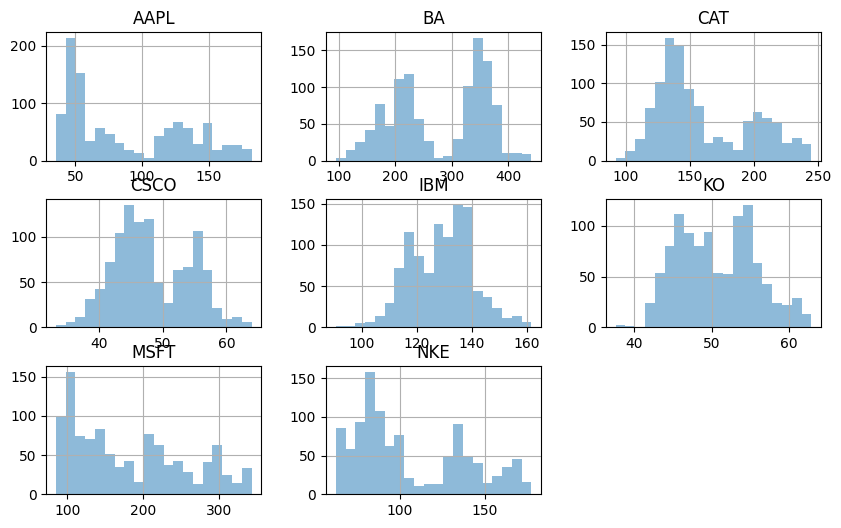

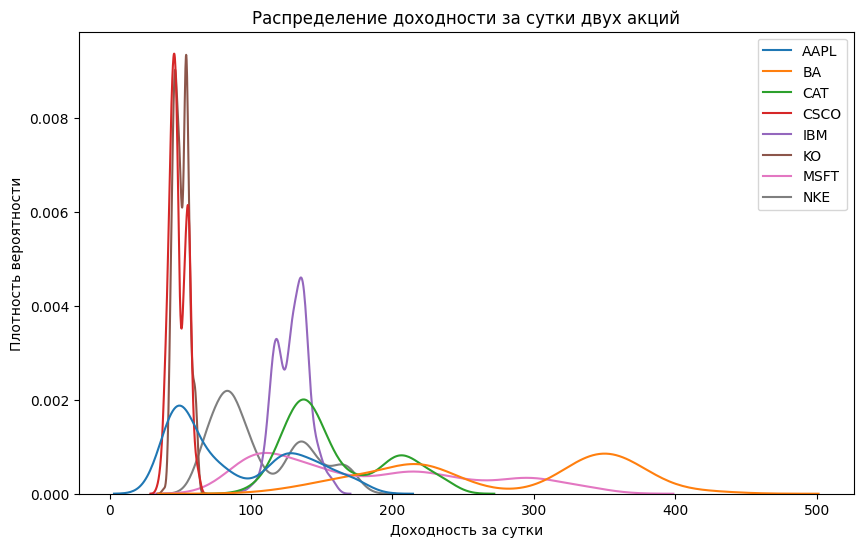

In [21]:
# чтение данных

# укажите где расположен файл с данными
path: str = 'C:\Dev\hw_pankr\cw.csv'

PATH_ERROR_TEXT: str = 'некоррекнто прописан путь к данным'

def read_file(path: str) -> pd.DataFrame:
    """
    Функция считывает данные из файла и
    возвращает дата фрейм
    """
    if os.path.exists(path) and os.path.isfile(path):
        data = pd.read_csv(path, sep=';', index_col ='Date', parse_dates= ['Date'])
        return data
    else:
        raise ValueError(PATH_ERROR_TEXT) and sys.exit()


data =  read_file(path)


data.hist(bins=20, alpha=0.5)
plt.rcParams['figure.figsize'] = [10, 6] 
plt.show();


sns.kdeplot(data=data)
plt.xlabel('Доходность за сутки')
plt.ylabel('Плотность вероятности')
plt.title('Распределение доходности за сутки двух акций')
plt.rcParams['figure.figsize'] = [10, 6]
plt.show();

def validate(column: str) -> bool:
    if column not in data.columns:
       return False
    return True


### задание 1

In [25]:
def find_risk(column: str) -> float:
    """
    функция вычисляет риски для акций
    поменять нужно только второй параметр
    """
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return np.round(data[column].pct_change().dropna().std(), 3)

find_risk('AAPL')

0.021

### задание 2

In [32]:
def calculate_shapiro(column: str) -> float:
    """
    Вычисляет коэффициент Шапиро,
    меняем только название акций
      """
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(sst.shapiro(data[column].pct_change().dropna())[0], 2)


calculate_shapiro('CAT')

0.96

### задание 3

In [33]:
def find_p_value(column: str, income: float) -> float:
    """проверяем гипотезу - выводим п-значение"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(sst.ttest_1samp(data[column].pct_change().dropna(), income)[1], 4)

find_p_value('AAPL', 0.002)

0.4569

### задание 4

Межквартильный размах 0.012013236340585154
Второй квартиль -0.005193607590491034
Третий квартиль 0.00681962875009412
Медиана 0.0006925366462906535
Боксплот


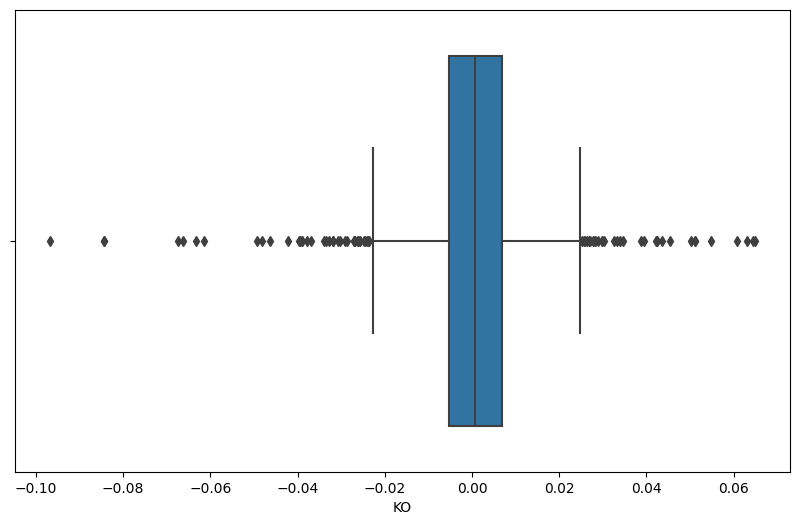

Детальный график


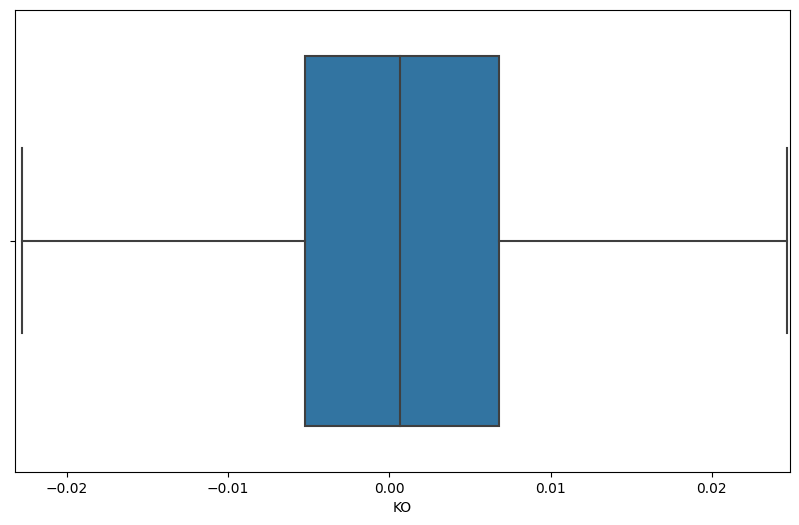

Точечный график


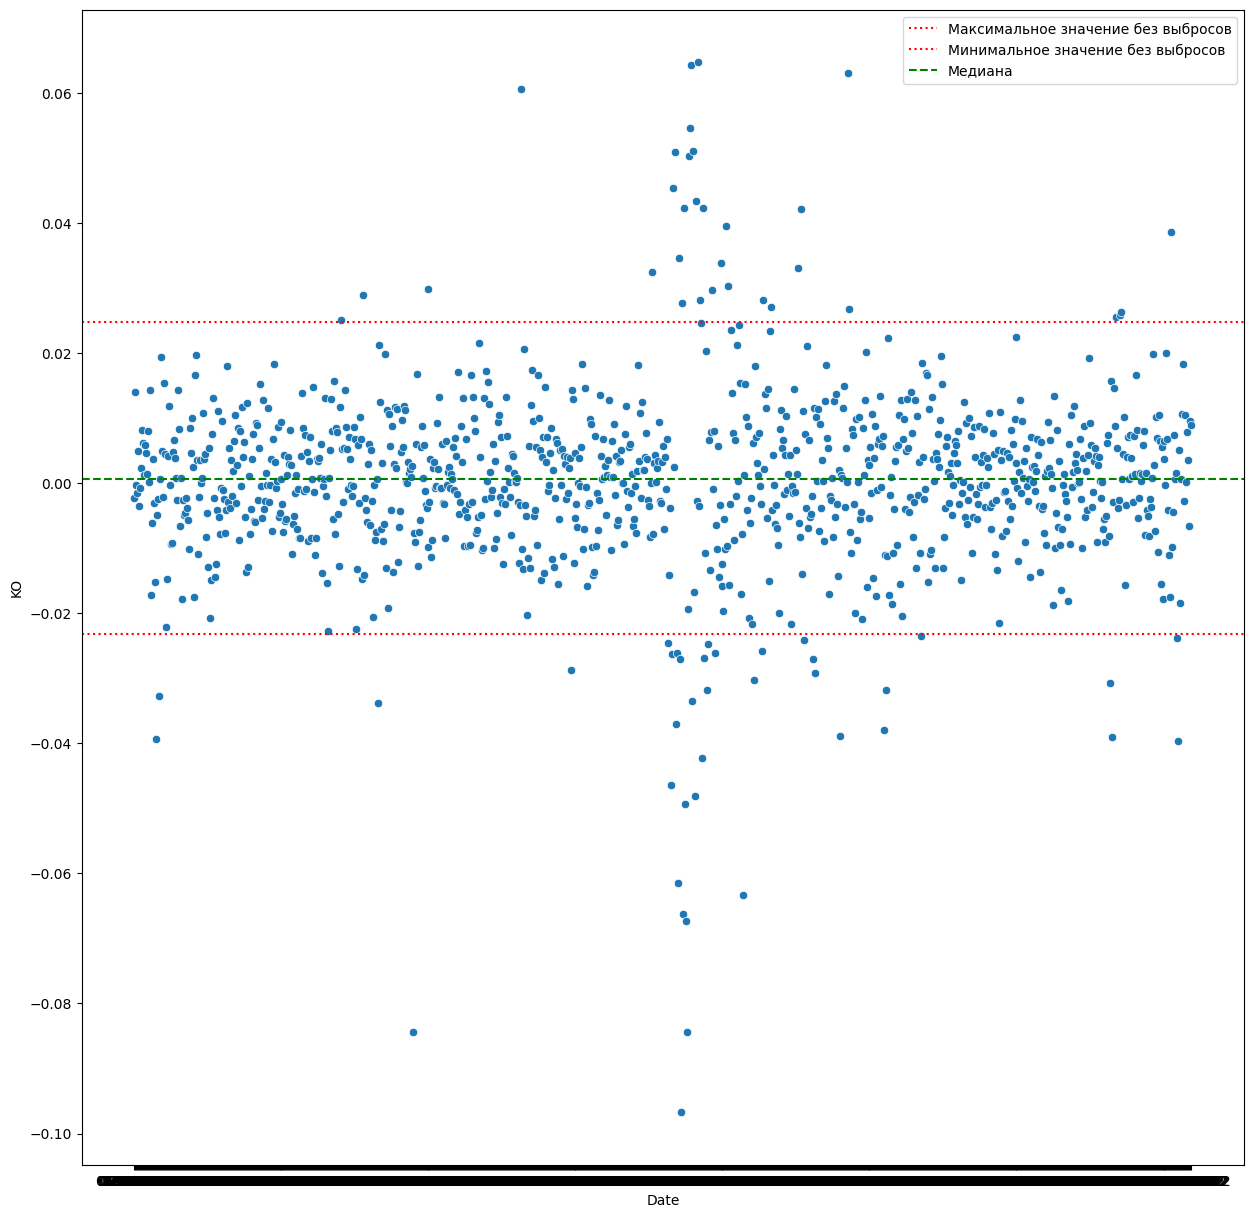

Index(['05.02.2018', '08.02.2018', '30.10.2018', '30.11.2018', '24.12.2018',
       '14.02.2019', '11.03.2019', '23.07.2019', '02.10.2019', '30.01.2020'],
      dtype='object', name='Date')
выбросов % -  6.57


In [37]:
class BoxMath:
    """
    Класс содержит анализ по выбросам
    """


    def __init__(self, df: pd.DataFrame, column: str) -> None:
        """
        активация...
        """
        self.df = df
        self.column = column
        if self.column  not in set(self.df.columns):
            raise ValueError('ошибка при формировании класса')
        if self.df[self.column].isna().sum() > 0:
            raise ValueError('убери пропуски')

    @property
    def metrix(self) -> dict[str: float]:
        """
        Рассчитываем показатели:
        -второй квартиль
        -третий квартиль
        -межквартильный размах
        """
        q75, q25 = np.percentile(self.df[self.column], [75 ,25])
        iqr: float = q75 - q25
        metrixs: dict[str: float] = {'iqr': iqr,
                                     'q75': q75,
                                     'q25': q25}
        return metrixs
    
    @property
    def max_not_anom(self) -> float:
        """
        Вычисляет верхнюю границу усов
        """
        max_not_anom: float = self.metrix['q75'] + 1.5 * self.metrix['iqr']
        if (max_not_anom > self.df[self.column].max()):
            return self.df[self.column].max()
        else:
            return max_not_anom

    @property
    def min_not_anom(self) -> float:
        """
        Вычисляет нижнюю границу усов
        """
        min_not_anom: float = self.metrix['q25'] - 1.5*self.metrix['iqr']
        if min_not_anom < self.df[self.column].min():
            return self.df[self.column].min()
        else:
            return min_not_anom
    
    @ property
    def anomalies(self) -> pd.DataFrame:
        """
        аномальные значения
        """
        anomalies: pd.Series = (self.df
                                [(
                                    self.df[self.column] < self.min_not_anom
                                ) | (
                                     self.df[self.column] > self.max_not_anom
                                    )][self.column])
        return anomalies
    
    @property
    def anomalies_indexs(self) -> pd.Series:
        """Возращает индексы аномальных строк"""
        return self.anomalies.index
    
    @property
    def min_p_anom(self) -> float:
        """минималльный положительный выброс по доходности"""
        return self.anomalies[self.anomalies > 0].min()



class BoxVisualisation:
    """
    Строим графики к выбросам
    """


    def __init__(self, math_object: BoxMath) -> None:
        self.math_object = math_object

    def represent_box(self) -> None:
        """выводит бокс-плот"""
        sns.boxplot(x=self.math_object.df[self.math_object.column])
        plt.show();

    def represent_scatter(self) -> None:
        """"выводит точечный"""
        plt.figure(figsize=(15,15))
        sns.scatterplot(x=self.math_object.df.index,
                        y=self.math_object.df[self.math_object.column])
        plt.axhline(y=self.math_object.max_not_anom,
                    color='red',
                    linestyle='dotted',
                    label='Максимальное значение без выбросов')
        plt.axhline(y=self.math_object.min_not_anom,
                    color='red',
                    linestyle='dotted',
                    label='Минимальное значение без выбросов')
        plt.axhline(y=self.math_object.df[self.math_object.column].median(),
                    color='green',
                    linestyle='--',
                    label='Медиана')
        plt.legend()
        plt.show();

    def represent_in_detail(self) -> None:
        """приближенный бокс-плот"""
        sns.boxplot(
            x=self.math_object.df[self.math_object.column]
            ).set_xlim([self.math_object.min_not_anom,
                        self.math_object.max_not_anom])
        plt.show();


class PrinterReport:
    """Выводим отчет"""


    def __init__(self, math_object: BoxMath,
                 visual_object: BoxVisualisation) -> None:
        self.math_object = math_object
        self.visual_object = visual_object
    
    def print_result(self) -> None:
        print('Межквартильный размах', self.math_object.metrix['iqr'])
        print('Второй квартиль', self.math_object.metrix['q25'])
        print('Третий квартиль', self.math_object.metrix['q75'])
        print('Медиана', self.math_object.df[self.math_object.column].median())
        print('Боксплот')
        self.visual_object.represent_box()
        print('Детальный график')
        self.visual_object.represent_in_detail()
        print('Точечный график')
        self.visual_object.represent_scatter()
        print(self.math_object.anomalies_indexs[:10])
        print('выбросов % - ', round((len(self.math_object.anomalies) / len( self.math_object.df)) * 100, 2))

# Example

mine: BoxMath = BoxMath(data.pct_change().dropna(), 'KO')
vis: BoxVisualisation = BoxVisualisation(mine)
report: PrinterReport = PrinterReport(mine, vis)
report.print_result()



In [10]:
def find_min_p_anomal(column: str) -> float:
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(BoxMath(data.pct_change().dropna(), column).min_p_anom, 3)

find_min_p_anomal('KO')


0.025

In [11]:
# Задание 5
# ?

### задание 6

In [34]:
def number_period(column: str, value: int) -> int:
    """
    кол-во периодов, стоимрость больше значения
    меняем только название акции
    """
    return sum(data[column] > value)


number_period('CAT', 170)

348

### задание 7

In [13]:
def mean_income(column: str) -> float:
    """Выводим среднюю доходность"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(data[column].pct_change().dropna().mean(), 5)

mean_income('AAPL')

0.00153

### задание 8

In [29]:
def calc_interval(column: str) -> float:
    """верхяя граница доверительного интервала для средней доходности"""
    if column not in data.columns:
        raise ValueError('нет такой компании, перепроверь!')
    return round(ssw.DescrStatsW(data.pct_change().dropna()[column]).tconfint_mean(alpha=0.95)[1], 5)

calc_interval("AAPL")

0.00157

### задание 9

In [15]:
# ttest о равенстве средней доходности - внимание на даты
group_1 = data.pct_change().dropna().loc['02.03.2020':'31.03.2020']['KO']
group_2 = data.pct_change().dropna().loc['01.03.2021':'31.03.2021']['KO']

round(sst.ttest_ind(group_1, group_2)[0], 2)

-0.96

### задание 10

In [16]:

def find_min_income_day(column: str):
    """наименьшая доходность акциии"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return data[column].pct_change().dropna().idxmin()

find_min_income_day('MSFT')

'16.03.2020'

### задание 11

0.0105
0.0029


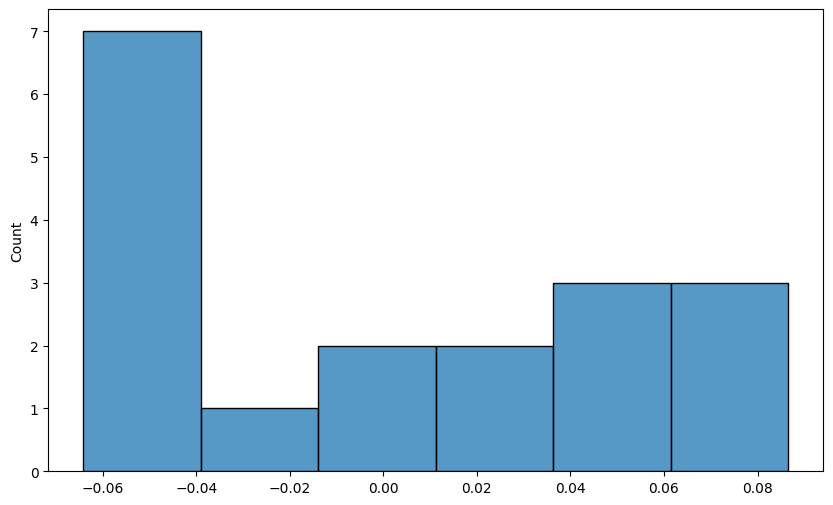

In [17]:
# 11 задание - что-то совсем плохое - точечная оценка средней доходности

# разница средних
print(round(group_2.mean()-group_1.mean(), 4))

# mean difference per day
index_1 = [index[0:5] for index in group_1.index]
index_2 = [index[0:5] for index in group_2.index]
g1 = group_1.to_dict()
g2 = group_2.to_dict()
common_days = list(set(index_1).intersection(set(index_2)))
diff = [g2[day + '.2021'] - g1[day + '.2020'] for day in common_days]
sns.histplot(diff)
print(round(sum(diff)/len(diff), 4))


### 12 задание

In [28]:
def calculate_iqr(column: str) -> float:
    """Находит межквартильный размах"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return round(BoxMath(data, column).metrix['iqr'], 2)

calculate_iqr('NKE')

52.95

### 13 задание

In [19]:

def find_max_income_day(column: str):
    """находит дату максимальной доходности"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return data[column].pct_change().dropna().idxmax()

find_max_income_day('MSFT')

'13.03.2020'

### 14 задание

In [20]:

def count_anomalies(column: str) -> int:
    """Считает кол-во аномалтй"""
    if not validate(column):
        raise ValueError('нет такой компании, перепроверь!')
    return len(BoxMath(data.pct_change().dropna(), column))

count_anomalies('BA')

70